# Advanced Lane finding 

Through this project, we will explore computer vision techniques to programmatically figure out the lanes in the pictures and then, overlay the marking on left and right lines. In addition, we will also build a robust pipeline to be tested on unseen images. We will also test our pipeline on video frame by frame.

## Our Approach

Our approach will consist of following steps:

1.Read many chessboard images to calibrate the camera. 

2.Undistort the images using calibrated camera matrix

3.Use thresholding in both gradient and colorspaces to isolate the lane markings. The output of this step ahoudl be a binary image.

4.Using the binary image, we will then figure out the points associated with left and right lane markings. 

5.We will then use perpective tranform to move from front view and 

6.We will then fit the polynomial to the left and right line curves. 

7.Finally, we will apply the inverse camera perspective tranform 

In [1]:
#Loading all the required libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import numpy as np
import pdb
from pathlib import Path
from glob import glob
%matplotlib inline

### Calibrating camera

In [2]:
#Specifying the path for the calibration images
ROOT = Path("D:/SelfDriving/Term1/Project4/CarND-Advanced-Lane-Lines/")

cal_path = ROOT/"camera_cal//"

imgs = glob(str(cal_path/"*.jpg"))

In [3]:
#Number of corners in each image to be found
nx=9
ny=6

In [4]:
def find_corners(images,nx,ny):
    """
    function to find corners from all the chessboard images
    and if dound, append them in an array
    
    """
    objps=[]
    imgps=[]
    objp=np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for img in images:
        imgrd = mpimg.imread(img)
        gray = cv2.cvtColor(imgrd,cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret:
            objps.append(objp)
            imgps.append(corners)
    return objps,imgps
            

In [5]:
objps,imgps = find_corners(imgs,nx,ny)

In [6]:
def undistort(img,objps,imgps):
    """function to calibrate the camera and undistort the image"""
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objps, imgps, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

In [7]:
img_undist= undistort(mpimg.imread(imgs[0]),objps,imgps)

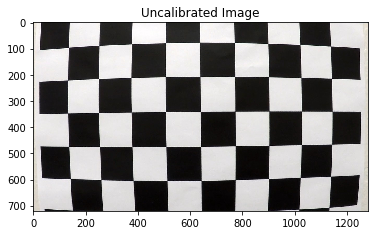

In [8]:
plt.imshow(mpimg.imread(imgs[0]),cmap='gray')
plt.title('Uncalibrated Image')
plt.show()

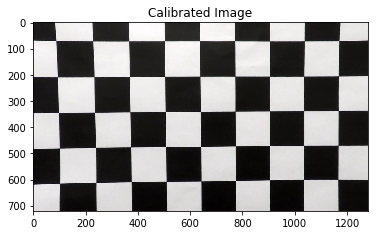

In [9]:
plt.imshow(img_undist,cmap='gray')
plt.title('Calibrated Image')

plt.imsave(fname="calibrated_image.png",arr=img_undist)
plt.show()


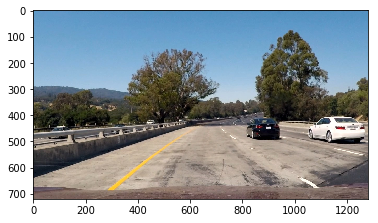

In [10]:
img_car = mpimg.imread("D:/SelfDriving/Term1/Project4/CarND-Advanced-Lane-Lines/test_images/test1.jpg")
plt.imshow(img_car)

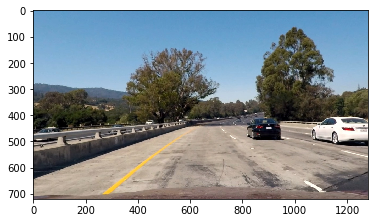

In [11]:
img_car_undistort= undistort(img_car,objps,imgps)
plt.imshow(img_car_undistort)
plt.imsave("output_images/car_undistorted.png",img_car_undistort)

In [12]:
def thresholdingX(img,thresh=(0,255)):
    """function to calculate gradient in X direction and then output the binary image 
    based on some gradient threshold values"""
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobx = cv2.Sobel(gray,cv2.CV_64F,0,1)
    sobx = np.absolute(sobx)
    scaled = np.uint8(255*sobx/np.max(sobx))
    binary_img = np.zeros_like(scaled)
    binary_img[(scaled>=thresh[0])&(scaled<=thresh[1])]=1    
    return binary_img
    

In [13]:
def thresholdingY(img,thresh=(0,255)):
    """function to calculate gradient in y direction and then output the binary image 
    based on some gradient threshold values"""
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    soby = cv2.Sobel(gray,cv2.CV_64F,1,0)
    soby = np.absolute(soby)
    scaled = np.uint8(255*soby/np.max(soby))
    binary_img = np.zeros_like(scaled)
    binary_img[(scaled>=thresh[0])&(scaled<=thresh[1])]=1
    
    return binary_img
    

In [14]:
def thresholding_dir(img,thresh=(0,np.pi/2)):
    """function to calculate gradient direction and then output the binary image 
    based on some gradient threshold values"""
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobx = cv2.Sobel(gray,cv2.CV_64F,0,1)
    soby = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobx = np.absolute(sobx)
    soby = np.absolute(soby)
    grad_dir = np.arctan2(soby,sobx)
    binary_img = np.zeros_like(grad_dir)
    binary_img[(grad_dir>=thresh[0])&(grad_dir<=thresh[1])]=1
    
    return binary_img
    

In [15]:
def thresholding_mag(img,thresh=(0,255)):
    """function to calculate gradient magnitude and then output the binary image 
    based on some gradient threshold values"""
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobx = cv2.Sobel(gray,cv2.CV_64F,0,1)
    soby = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobx = np.absolute(sobx)
    soby = np.absolute(soby)
    grad_mag = np.sqrt(np.square(sobx)+np.square(soby))
    scaled = np.uint8(255*grad_mag/np.max(grad_mag))
    binary_img = np.zeros_like(scaled)
    binary_img[(scaled>=thresh[0])&(scaled<=thresh[1])]=1
    
    return binary_img
    

In [16]:
def thresholding_color(img,thresh=(0,255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_img = np.zeros_like(s)
    binary_img[(s>=thresh[0])&(s<=thresh[1])]=1    
    return binary_img
    

In [17]:
imgt = mpimg.imread("D:/SelfDriving/Term1/Project4/CarND-Advanced-Lane-Lines/test_images/test3.jpg")
grayt = cv2.cvtColor(imgt,cv2.COLOR_RGB2GRAY)

In [18]:
binary_color = thresholding_color(imgt,thresh=(80,255))
binaryx = thresholdingX(imgt,thresh=(40,200))
binaryy = thresholdingY(imgt,thresh=(40,200))

In [19]:
new_image = np.zeros_like(binary_color)
new_image[((binaryx==1) & (binaryy==1)) | (binary_color==1)]=1

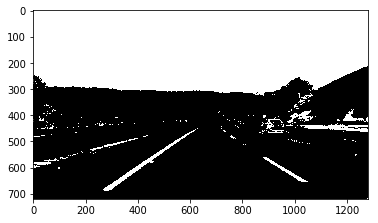

In [20]:
imgout= plt.imshow(new_image,cmap='gray')
plt.show()
imgout.write_png('output_images/binary_image_test3.png')

In [21]:
def perspective_transform(img):
    offset=300
    src = np.float32([[260,680],[580,460],[700,460],[1050,680]])
    dst = np.float32([[offset,img.shape[0]-20],[offset,0],[img.shape[1]-offset,0],[img.shape[1]-offset,img.shape[0]-20]])
    persM = cv2.getPerspectiveTransform(src,dst)
    invM = cv2.getPerspectiveTransform(dst,src)
    return invM,cv2.warpPerspective(img,persM,(img.shape[1],img.shape[0]),flags=cv2.INTER_LINEAR)
    

In [22]:
image_test = mpimg.imread('D:/SelfDriving/Term1/Project4/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

_,warped =perspective_transform(image_test)

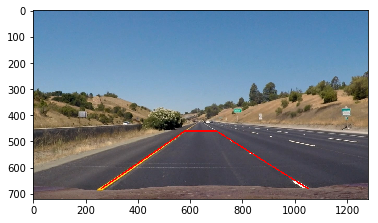

In [23]:
image_ovr=cv2.line(image_test,(260,680),(580,460),thickness=3,color=(255,0,0))
image_ovr=cv2.line(image_test,(700,460),(1050,680),thickness=3,color=(255,0,0))
image_ovr=cv2.line(image_test,(700,460),(580,460),thickness=3,color=(255,0,0))


plt.imshow(image_ovr)
plt.imsave('output_images/lane_box_straight1.jpg',image_ovr)

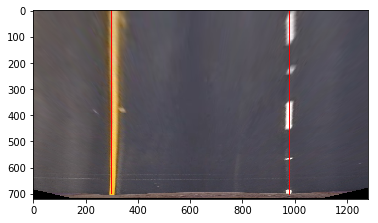

In [24]:
warped_ovr = cv2.line(warped,(300,warped.shape[0]-20),(300,0),thickness=4,color=(255,0,0))
warped_ovr = cv2.line(warped,(warped.shape[1]-300,0),(warped.shape[1]-300,warped.shape[0]-20),thickness=4,color=(255,0,0))


plt.imshow(warped_ovr)
plt.imsave('output_images/warped_straight1.jpg',warped_ovr)

In [25]:
def image2binaryandtransform(img):
    img_undist = undistort(img,objps,imgps)
    binaryx = thresholdingX(img_undist,thresh=(40,200))
    binaryy= thresholdingY(img_undist,thresh=(40,200))
    binary_col= thresholding_color(img_undist,thresh=(80,255))
    binaryimg = np.zeros_like(binaryx)
    binaryimg[(binaryy==1)&(binaryx==1)|(binary_col==1)]=1 
    return binaryimg

In [26]:
def imageReadAndTransform(imagePath,Path=True):
    if Path: img = mpimg.imread(imagePath)
    else: img=imagePath
    binary = image2binaryandtransform(img)
    invM,tranformed = perspective_transform(binary)
    
    return invM,tranformed

In [27]:
class line(object):
    def __init__(self, smoothing=0.1):
        self.oldX = np.array([])
        self.oldfit = np.array([])
        self.smoothing = smoothing
        self.avg_fit = None
        #self.avgX = None
        #self.currentX=np.array([])
        self.currentfit=np.array([])
    def updatefit(self,currentfit,frame_number):
    
        self.currentfit = currentfit
        #pdb.set_trace()
        if frame_number > 10:
            #print("entered!")          
            self.avgfit = self.smoothing*currentfit + (1-self.smoothing)*self.oldfit
        else:
            self.avgfit = currentfit
        self.oldfit = self.avgfit
        

In [28]:
def fitlineAndproject(img,calculateRad=True,calculatecentredev=True,fnum=0,lline=None,rline=None):
    """
    This function takes image as input and finds the left and right markers"""
   
    #read image, convert to binary, edge detects, and perform perspective transform
    invM,transformed = imageReadAndTransform(img,Path=False)
    
    #started code for searching and fitting the left/right lines
    w,h =transformed.shape[1],transformed.shape[0]
    hist=np.sum(transformed[h//2:,:],axis=0)
    left_start,right_start = np.argmax(hist[:w//2]), (w//2+np.argmax(hist[w//2:]))
    nw = 9
    nony,nonx=transformed.nonzero()
    llane_coords =[]
    rlane_coords =[]
    left_pointer = left_start
    right_pointer = right_start
    margin = 100
    minpix = 50
    window_height = transformed.shape[0]//nw
    
    
    if fnum==0:
        #need to search for left and right line markers for the first time
        for i in range(nw):
            win_y_min = transformed.shape[0] - (i+1)*window_height
            win_y_max = transformed.shape[0] - i*window_height
            win_xleft_min = left_pointer - margin
            win_xleft_max = left_pointer + margin
            win_xright_min = right_pointer - margin
            win_xright_max = right_pointer + margin
            #cv2.rectangle(out_img,(win_xleft_min,win_y_min),(win_xleft_max,win_y_max),
            #(255,0,0), 2) 
            #cv2.rectangle(out_img,(win_xright_min,win_y_min),(win_xright_max,win_y_max),
            #(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nony >= win_y_min) & (nony < win_y_max) & 
            (nonx >= win_xleft_min) &  (nonx < win_xleft_max)).nonzero()[0]
            good_right_inds = ((nony >= win_y_min) & (nony < win_y_max) & 
            (nonx >= win_xright_min) &  (nonx < win_xright_max)).nonzero()[0]
            # Append these indices to the lists
        
            llane_coords.append(good_left_inds)
            rlane_coords.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_pointer = np.int(np.mean(nonx[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_pointer = np.int(np.mean(nonx[good_right_inds]))
                
        llane_coords = np.concatenate(llane_coords)
        rlane_coords = np.concatenate(rlane_coords)
    else:
        #perform narrow search around the previously detected lines
        prevl_coords = nony**2*lline.oldfit[0] + lline.oldfit[1]*nony + lline.oldfit[2]
        prevr_coords = nony**2*rline.oldfit[0] + rline.oldfit[1]*nony + rline.oldfit[2]
        llane_coords = (nonx >= prevl_coords-margin) & (nonx < prevl_coords+margin)
        rlane_coords = (nonx >= prevr_coords-margin) & (nonx < prevr_coords+margin)
        
    #extract the left and right line points and perform polynomial fitting
    leftx = nonx[llane_coords]
    lefty = nony[llane_coords]
    rightx = nonx[rlane_coords]
    righty = nony[rlane_coords]
    left_fit = np.polyfit(lefty,leftx,deg=2)
    right_fit = np.polyfit(righty,rightx,deg=2)
    
    #update the fit in each of the line class
    lline.updatefit(left_fit,fnum)
    rline.updatefit(right_fit,fnum)
    
    
    ploty = np.linspace(0,transformed.shape[0]-1,transformed.shape[0])
    warp_zero = np.zeros_like(transformed).astype(np.uint8)    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = lline.avgfit[0]*ploty**2 +lline.avgfit[1]*ploty +lline.avgfit[2]
    right_fitx = rline.avgfit[0]*ploty**2 + rline.avgfit[1]*ploty + rline.avgfit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, invM, (img.shape[1], img.shape[0])) 
    ym_pixel = 30/720.
    xm_pixel = 3.7/700.
    
    if calculateRad:
        #roc = ((1.+(2*left_fit[0]*720+left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
        left_fit_cur = np.polyfit(lefty*ym_pixel,leftx*xm_pixel,deg=2)
        right_fit_cur = np.polyfit(righty*ym_pixel,rightx*xm_pixel,deg=2)
        roc_left = ((1.+(2*left_fit_cur[0]*720*ym_pixel+left_fit_cur[1])**2)**1.5)/np.absolute(2*left_fit_cur[0])
        roc_right = ((1.+(2*right_fit_cur[0]*720*ym_pixel+right_fit_cur[1])**2)**1.5)/np.absolute(2*right_fit_cur[0])
    else:
        roc_left,roc_right = None, None
    if calculatecentredev:
        image_center= img.shape[1]//2
        left_rd_start = lline.avgfit[0]*720**2 + 720*lline.avgfit[1] + lline.avgfit[2]
        right_rd_start = rline.avgfit[0]*720**2 + 720*rline.avgfit[1] + rline.avgfit[2]
        lane_center = (right_rd_start-left_rd_start)/2.0 + left_rd_start
        centerdev = (image_center-lane_center)*xm_pixel
    else:
        centerdev = None
        

    return left_fitx,right_fitx,roc_left,roc_right,centerdev,newwarp


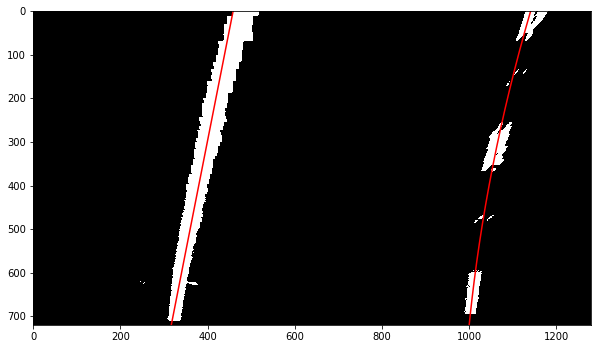

In [29]:
image_fit = mpimg.imread("D:/SelfDriving/Term1/Project4/CarND-Advanced-Lane-Lines/test_images/test3.jpg")
lline = line(smoothing=0.1)
rline=line(smoothing=0.1)
leftx,rightx,_,_,_,warped= fitlineAndproject(image_fit,calculateRad=False,calculatecentredev=False,lline=lline,rline=rline)
invM,transformed = imageReadAndTransform(image_fit,Path=False)
out_image = np.dstack((transformed,transformed,transformed))*255
ploty = np.linspace(0,image_fit.shape[0]-1,image_fit.shape[0])
plt.figure(figsize=(10,10))
new=plt.imshow(out_image,cmap='gray')
plt.plot(leftx,ploty,color='red')
plt.plot(rightx,ploty,color='red')
#new.write_png("output_images/fitted_poly.png")
plt.savefig("output_images/fitted_poly.png")


In [30]:
def overlayfittedline(img):
    """
    This function takes an image as input nd perform following steps:
    --undistort the image
    --call the fitlineAndproject function
    --overlay the polygon returned by fitlineAndproject function on the undistorted image
    return the overlaid image
    """
    lline = line(smoothing=0.1)
    rline=line(smoothing=0.1)
    
    undist = undistort(img,objps,imgps)
    _,_,rocl,rocr,centerdev,newwarp = fitlineAndproject(img,calculateRad=True,calculatecentredev=True,fnum=0,lline=lline,rline=rline)
    #print("radius of curvature(in meters) left:{}, right:{}".format(rocl,rocr))
    #print("Center deviation in meteres:{}".format(centerdev))
    return rocl,rocr,centerdev,cv2.addWeighted(undist,1,newwarp,0.3,0)
    
    

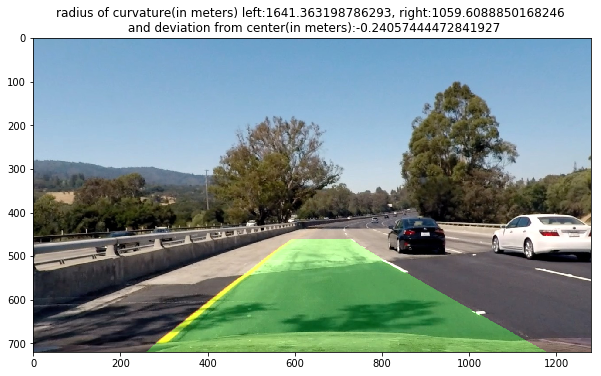

In [31]:
plt.figure(figsize=(10,10))
rocl,rocr,cdev,fimage = overlayfittedline(mpimg.imread(str(ROOT/"test_images/test4.jpg")))
plt.imshow(fimage)
plt.title("radius of curvature(in meters) left:{}, right:{} \n and deviation from center(in meters):{}".format(rocl,rocr,cdev))
plt.savefig('output_images/final_image.png')


In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(img):
    global frame_number,left_line,right_line    
    undist = undistort(img,objps,imgps)
    _,_,_,_,_,warped=fitlineAndproject(img,fnum=frame_number,lline=left_line,rline=right_line)
    frame_number+=1
    return cv2.addWeighted(undist,1,warped,0.3,0)

In [39]:
frame_number =0
left_line= line(smoothing=0.1)
right_line = line(smoothing=0.1)
white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [37:55<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 37min 57s
